In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
import gc
import warnings
from datetime import datetime

# 1.源数据的读取

In [3]:
df_origin = pd.read_csv('../UserBehavior.csv')

# 2.源数据补全列名，打印信息

In [15]:
df_origin.columns = ['UserID', 'ItemID', 'CatogoryID', 'BehaviorType', 'TimeStamps']
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100150806 entries, 0 to 100150805
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   UserID        int64 
 1   ItemID        int64 
 2   CatogoryID    int64 
 3   BehaviorType  object
 4   TimeStamps    int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ GB


# 3.取样100w条数据进行便于后续分析

In [13]:

df_Second = df_origin.dropna()
df_Second = df_Second.drop_duplicates(subset=['UserID', 'ItemID', 'TimeStamps'])
df_Second = df_Second.sample(frac=0.01, random_state=1)
df_Second.to_csv('../UserBehavior-2.csv')


# 4.提高时间信息的可读性

In [38]:
df_Second = pd.read_csv('../UserBehavior-2.csv')
startTime = time.mktime(time.strptime("2017-11-25 00:00:00", "%Y-%m-%d %H:%M:%S"))
endTime = time.mktime(time.strptime("2017-12-3 23:59:59", "%Y-%m-%d %H:%M:%S"))
df_Second = df_Second.loc[(df_Second['TimeStamps'] >= startTime) & (df_Second['TimeStamps'] <= endTime)]


df_Second["time"] = df_Second["TimeStamps"].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
df_Second['weekday'] = pd.to_datetime(df_Second['time'], format="%Y-%m-%d %H:%M:%S").dt.day_name()
df_Second['date'] = df_Second['time'].str[0:10]
df_Second['date'] = pd.to_datetime(df_Second['date'], format='%Y-%m-%d')
df_Second['time'] = df_Second['time'].str[11:13]
df_Second['time'] = df_Second['time'].astype(int)
df_Second['hour'] = pd.cut(df_Second['time'], bins=[-1, 5, 10, 13, 18, 24], labels=['morning', 'forenoon', 'noon', 'afternoon', 'night'])
df_Second = df_Second.drop(columns=['time'])
df_Second.drop(labels=['Unnamed: 0','TimeStamps'],axis=1,inplace=True)

df_Second.head()

,UserID,ItemID,CatogoryID,BehaviorType,weekday,date,hour
0,205131,2664389,1320293,pv,Monday,2017-11-27,night
1,808910,2619425,2355072,pv,Sunday,2017-11-26,afternoon
2,92422,5062111,3138705,pv,Sunday,2017-11-26,morning
3,901476,1632442,2013232,pv,Monday,2017-11-27,morning
4,49272,2371018,3184456,pv,Sunday,2017-12-03,afternoon


# 5.数据验证

In [35]:
print(df_Second.duplicated().any())
print(df_Second.isnull().any())
print(df_Second.date.min())
print(df_Second.date.max())

True
UserID          False
ItemID          False
CatogoryID      False
BehaviorType    False
weekday         False
date            False
hour            False
dtype: bool
2017-08-06 00:00:00
2017-12-03 00:00:00


BehaviorType
buy      3.356369
cart     8.762414
fav      4.418669
pv      83.462548
Name: UserID, dtype: float64

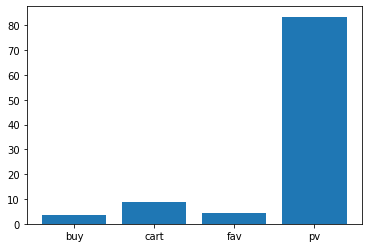

In [46]:
bt_persent = df_Second.groupby(by='BehaviorType')['UserID'].nunique() / df_Second.groupby(by='BehaviorType')['UserID'].nunique().sum()*100
plt.bar(bt_persent.index,bt_persent.values)
bt_persent